## Model Selection Notebook

This notebook will perform model selection on a random forest ensemble to predict 3 way classification

- Home Win
- Away Win
- Draw

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import sem

numFolds = 5

In [17]:
# Load data
data = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/20170212_Matches_w_Features.csv')

In [18]:
print len(data)
print data.shape

2280
(2280, 212)


In [19]:
home_goals = data['home_team_goal']
away_goals = data['away_team_goal']

In [20]:
del data['home_team_goal']
del data['away_team_goal']

In [21]:
print data.shape

(2280, 210)


## Find Best Features

In [22]:
features = data.copy()
target = features['Result_Target']
del features['Result_Target']

features_model = RandomForestClassifier(n_estimators = 500, max_depth = 5)

mdl = features_model.fit(features,target)

importances = mdl.feature_importances_



In [23]:
feature_importances = pd.DataFrame({'Feature':features.columns, 'Importances':importances})

feature_importances = feature_importances.sort_values('Importances',ascending = False).reset_index(drop=True)

In [24]:
feature_importances['Cum_Sum'] = feature_importances['Importances'].cumsum()
feature_importances[:80]

,Feature,Importances,Cum_Sum
0,BWH,0.044888,0.044888
1,Average_Away_Odds,0.044136,0.089024
2,IWA,0.043309,0.132333
3,WHA,0.040162,0.172495
4,IWH,0.039063,0.211558
5,B365H,0.038817,0.250375
6,Average_Home_Odds,0.037046,0.287422
7,LBH,0.036670,0.324092
8,BWA,0.035900,0.359991
9,VCH,0.035348,0.395339


In [25]:
## First step is to set up training and holdout set
def Assign_Train_Test(df):
    num = random.randint(1,numFolds)
    return num

In [33]:
target = data['Result_Target'].copy()
data = data[feature_importances['Feature'][:80]]
data['Result_Target'] = target

In [34]:
data['Train_Test'] = data.apply(Assign_Train_Test, axis = 1)

In [35]:
## Chose holdout set as approx 10% of data
holdout = data[data['Train_Test']==1]
train = data[data['Train_Test']!= 1]

# Remove the train_test variable from the dataframes
del holdout['Train_Test']
del train['Train_Test']

print 'Test length ' + str(len(holdout))
print 'Train length ' + str(len(train))

Test length 475
Train length 1805


In [36]:
def FitPredict(x_train,y_train,x_test,model):
    
    fit_model = model.fit(x_train,y_train)
    preds = fit_model.predict(x_test)
    
    return preds

def ComputeErrorMetric(y_true,y_pred):
    
    df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    # home_wins
    hw_fp = ((df.y_true != 1) & (df.y_pred == 1))
    hw_tp = ((df.y_true == 1) & (df.y_pred == 1))
    hw_fn = ((df.y_true == 1) & (df.y_pred != 1))
    hw_tn = ((df.y_true != 1) & (df.y_pred != 1))
    # away_win
    aw_fp = ((df.y_true != -1) & (df.y_pred == -1))
    aw_tp = ((df.y_true == -1) & (df.y_pred == -1))
    aw_fn = ((df.y_true == -1) & (df.y_pred != -1))
    aw_tn = ((df.y_true != -1) & (df.y_pred != -1))
    #  draw
    dd_fp = ((df.y_true != 0) & (df.y_pred == 0))
    dd_tp = ((df.y_true == 0) & (df.y_pred == 0))
    dd_fn = ((df.y_true == 0) & (df.y_pred != 0))
    dd_tn = ((df.y_true != 0) & (df.y_pred != 0))

    true_positive = sum(hw_tp + aw_tp + dd_tp)
    false_positive = sum(hw_fp + aw_fp + dd_fp) 
    true_negative = sum(hw_tn + aw_tn + dd_tn)
    false_negative = sum(hw_fn + aw_fn + dd_fn)

    combined_error_metric = 11.0/13.0*false_positive/(false_positive+true_negative)+2.0/13.0*false_negative/(false_negative+true_positive)
    
    #precision = true_positive / (true_positive + false_positive)
    #recall = true_positive / (true_positive + false_negative)
    
    return round(combined_error_metric,2)

def FindBParams(params_dict):
    b_inner_params = []
    
    best_score = min(params_dict.values())

    for key in params_dict.keys():
        if params_dict[key] == best_score:
            b_inner_params.append(key)
    
    vals=b_inner_params[0].split('_')
        
    depth = vals[0]
    n_trees = vals[1]
        
    return depth,n_trees

In [37]:
## Use Assign_Train_Test to assign cross-validation folds

train['Fold'] = train.apply(Assign_Train_Test,axis = 1)

train['Fold'].value_counts()   #All folds are approximately equal size

/Users/mtetkosk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


5    384
2    366
3    357
4    350
1    348
Name: Fold, dtype: int64

In [41]:
## Set up cross-validation loop

cv_accuracy = []
cv_precision = []
cv_recall = []

depths = [3,4,5,6]
num_estimators = [50,100,200]

outer_param_scores = {}
outer_error_metric = []

for fold in range(1,numFolds+1):
    
    # Outer Cross-Validation
    
    cv_train = train[train['Fold'] != fold]
    cv_test = train[train['Fold'] == fold]
    
    del cv_train['Fold']
    del cv_test['Fold']
    
    y_train = cv_train['Result_Target']
    x_train = cv_train.copy()
    del x_train['Result_Target']

    
    y_test = cv_test['Result_Target']
    del cv_test['Result_Target']
    x_test = cv_test.copy()
    
    # Set up inner cross-validation
    
    inner_train = cv_train.copy()
    del cv_train['Result_Target']
    
    inner_train['Inner_Fold'] = inner_train.apply(Assign_Train_Test, axis = 1)
    
    best_hyper_params = {}
    #se = {}
    
    # Iterate thru hyperparameter search
    for depth in depths:
        for n in num_estimators:
            
            error_metric = []
    
            for inner_fold in range(1,numFolds+1):
        
                inner_cv_train = inner_train[inner_train['Inner_Fold']!= inner_fold]
                inner_cv_test = inner_train[inner_train['Inner_Fold']== inner_fold]
        
                del inner_cv_train['Inner_Fold']
                del inner_cv_test['Inner_Fold']
        
                y_inner_train = inner_cv_train['Result_Target']
                del inner_cv_train['Result_Target']
                x_inner_train = inner_cv_train.copy()
    
                y_inner_test = inner_cv_test['Result_Target']
                del inner_cv_test['Result_Target']
                x_inner_test = inner_cv_test.copy()
                
                clf = RandomForestClassifier(n_estimators = n, max_depth = depth,n_jobs = -1,random_state = 17)
                #clf = AdaBoostClassifier(n_estimators = n, learning_rate = depth)
                
                preds = FitPredict(x_inner_train,y_inner_train,x_inner_test,clf) 
    
                cem = ComputeErrorMetric(y_inner_test,preds)  # Calculate combined error metric
        
                error_metric.append(cem)
            
            avg_error_metric = np.mean(error_metric)
            #standard_error = sem(error_metric)
            param_names = str(depth) + '_' + str(n) 
            best_hyper_params[param_names] = (avg_error_metric)  #register inner-cv average
            #se[param_names] = standard_error
            
    depth,n_trees = FindBParams(best_hyper_params)
    
    clf = RandomForestClassifier(n_estimators = int(n_trees), max_depth = int(depth), n_jobs = -1,random_state = 17)
    #clf = AdaBoostClassifier(n_estimators = int(n_trees), learning_rate = float(depth))
    
    preds = FitPredict(x_train,y_train,x_test,clf)
    
    cem = ComputeErrorMetric(y_test,preds)
    
    outer_error_metric.append(cem)
    
    outer_param_names = str(depth) + '_' + str(n_trees)
    
    print 'Fold ' + str(fold) + ' Error Metric: ' + str(round(cem,2))
    print 'Best Params- ' + 'Depth= ' + str(depth) + ' Number of Trees= ' + str(n_trees)
    
    outer_param_scores[outer_param_names] = cem

avg_error_metric_outer = np.mean(outer_error_metric)

print '****************************************************'
print 'Average Error Metric= ' + str(avg_error_metric_outer)    

Fold 1 Error Metric: 0.36
Best Params- Depth= 4 Number of Trees= 50
Fold 2 Error Metric: 0.34
Best Params- Depth= 5 Number of Trees= 100
Fold 3 Error Metric: 0.33
Best Params- Depth= 4 Number of Trees= 50
Fold 4 Error Metric: 0.32
Best Params- Depth= 3 Number of Trees= 200
Fold 5 Error Metric: 0.35
Best Params- Depth= 6 Number of Trees= 200
****************************************************
Average Error Metric= 0.34


## Random Forest
From the nested cross validation above, the lowest error metric is 0.34.

A error metric for a completely random guess is 0.41, so there is some value in the model! (Though not that much..)

Now let's fit the best parameters from Fold 9. This happens to be the simplest set of parameters chosen.

Number of Trees = 1000, Max Depth = 3.

## AdaBoost

Average error metric for AdaBoost = .351

The best metric from inner cross validation is with the metric learning_rate = 0.1 and Number of Trees = 50.




## Test on holdout set

In [39]:
## Prepare for test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

x_train = train.copy()
x_test = holdout.copy()

y_train = x_train['Result_Target']
del x_train['Result_Target']
del x_train['Fold']

y_test = x_test['Result_Target']
del x_test['Result_Target']

#clf = RandomForestClassifier(n_estimators =1000,max_depth = 3, n_jobs = -1, random_state = 17)
clf = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.2)


preds = FitPredict(x_train,y_train,x_test,clf)

cem = ComputeErrorMetric(y_test,preds)



print 'Holdout Set Error Metric = ' + str(round(cem,2))
print

Holdout Set Error Metric = 0.37



In [40]:
df_confusion = pd.crosstab(y_test,preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,-1.0,0.0,1.0,All
Actual,,,,
-1.0,63,2,77,142
0.0,45,2,93,140
1.0,27,2,164,193
All,135,6,334,475


Home Win Precision = 55.5 %

Home Win Recall = 79.1 %

Away Win Precision = 44.15%

Away Win Recall = 51.5%

## Betting Analysis

In [89]:
test_home_odds = x_test['Average_Home_Odds'].copy()
test_away_odds = x_test['Average_Away_Odds'].copy()
bet_preds = preds.copy()
actual_results = y_test.copy()

In [90]:
Betting_df = pd.DataFrame({'Home_Odds':test_home_odds,'Away_Odds':test_away_odds,'Model_Preds':bet_preds,'Result': y_test.copy()})
Betting_df = Betting_df.reset_index(drop=True)
Betting_df

,Away_Odds,Home_Odds,Model_Preds,Result
0,7.69,1.45,1.0,1.0
1,3.48,2.12,1.0,1.0
2,3.53,2.07,1.0,1.0
3,2.07,3.51,-1.0,0.0
4,8.33,1.39,1.0,0.0
5,2.36,2.98,-1.0,-1.0
6,4.30,1.84,1.0,1.0
7,17.00,1.16,1.0,1.0
8,7.42,1.46,1.0,1.0
9,2.87,2.37,1.0,1.0


In [91]:
## Betting Analysis Function

def BettingAnalysis(df,purse,bet):
    initial_purse = purse
    purse_track = []
    for match in range(len(df)):
        pred = df['Model_Preds'][match]
        result = df['Result'][match]
        home_odds = df['Home_Odds'][match]
        away_odds = df['Away_Odds'][match]
        
        if pred == result:
            if pred == 1:
                win = round(bet*home_odds,2)-bet
                purse += win
            if pred == -1: #simulate no bet
                win = round(bet*away_odds,2)-bet
                purse += win
            purse_track.append(purse)
        else:
            purse = purse - bet
            purse_track.append(purse)
    
    if purse > initial_purse:
        profit = purse-initial_purse
        #return 'You profited ' +str(round(profit,2)) +'!'
        return purse_track
    if purse == initial_purse:
        #return 'You broke even!'
        return purse_track
    if purse < initial_purse:
        loss = purse-initial_purse
        #return 'You lost ' + str(abs(round(loss,2))) + 'now you\'re broke!'
        return purse_track

In [92]:
purse_track = BettingAnalysis(Betting_df,100,5)

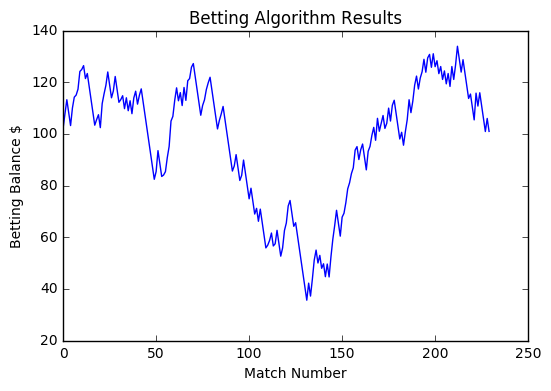

In [93]:
plt.plot(purse_track)
plt.xlabel('Match Number')
plt.ylabel('Betting Balance $')
plt.title('Betting Algorithm Results')

In [ ]:
Betting_df['purse'] = purse_track

In [ ]:
Betting_df